In [1]:
## Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Reading the train data
train_data = pd.read_csv('/kaggle/input/customer-life-time-prediction/train_BRCpofr.csv')
train = train_data.copy()
train.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [3]:
## Splitting the data into X and y
X = train.drop('cltv',axis=1)
y = train['cltv']

In [4]:
## removing id column since it won't be of any use in training machine learning model
X.drop('id',axis=1,inplace=True)

In [5]:
## finding out the names of categorical and numerical features in the data
cat_feat = [feature for feature in X.columns if X[feature].dtypes == 'O']
num_feat = [feature for feature in X.columns if feature not in cat_feat]

In [6]:
for column in X.columns:
    print(f"The unique values in the feature {column} are {X[column].unique()} (Total of {X[column].nunique()}). \n")

The unique values in the feature gender are ['Male' 'Female'] (Total of 2). 

The unique values in the feature area are ['Urban' 'Rural'] (Total of 2). 

The unique values in the feature qualification are ['Bachelor' 'High School' 'Others'] (Total of 3). 

The unique values in the feature income are ['5L-10L' 'More than 10L' '2L-5L' '<=2L'] (Total of 4). 

The unique values in the feature marital_status are [1 0] (Total of 2). 

The unique values in the feature vintage are [5 8 7 6 1 0 3 4 2] (Total of 9). 

The unique values in the feature claim_amount are [ 5790  5080  2599 ... 15361 12911 17143] (Total of 10889). 

The unique values in the feature num_policies are ['More than 1' '1'] (Total of 2). 

The unique values in the feature policy are ['A' 'C' 'B'] (Total of 3). 

The unique values in the feature type_of_policy are ['Platinum' 'Gold' 'Silver'] (Total of 3). 



In [7]:
## replacing outliers from the column claim_amount with the median of the column
quantiles = pd.DataFrame(X['claim_amount']).quantile(np.arange(0,1,0.25)).T
quantiles = quantiles.rename(columns={0.25:'Q1', 0.50: 'Q2', 0.75:'Q3'})

quantiles['IQR'] = quantiles['Q3'] - quantiles['Q1']
quantiles['Lower_Limit'] = quantiles['Q1'] - 1.5*quantiles['IQR']
quantiles['Upper_Limit'] = quantiles['Q3'] + 1.5*quantiles['IQR']

X['claim_amount'] = np.where((X['claim_amount'] < quantiles.loc['claim_amount','Lower_Limit']) | (X['claim_amount'] > quantiles.loc['claim_amount','Upper_Limit']) & (X['claim_amount'] is not np.nan), np.nan, X['claim_amount'])

In [8]:
## dealing with the missing values in numerical and categorical features
from sklearn.impute import SimpleImputer

imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
X['claim_amount'] = imputer1.fit_transform(X['claim_amount'].to_numpy().reshape(-1,1))

inputer2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for feature in cat_feat + ['vintage', 'marital_status']:
    X[feature] = inputer2.fit_transform(X[feature].to_numpy().reshape(-1,1))

In [9]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

oe1 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
oe2 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
oe3 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
ohe = OneHotEncoder(handle_unknown='ignore',drop='first')
mms = MinMaxScaler(feature_range=(0.01,1))

## dealing with the scaling of numerical feature
X['claim_amount'] = mms.fit_transform(X['claim_amount'].to_numpy().reshape(-1,1))
## applying log-transformation to the claim amount feature
X['claim_amount'] = np.log(X['claim_amount'])

## dealing with the encoding of categorical feature
X['income']  = oe1.fit_transform(X['income'].to_numpy().reshape(-1,1))
X['qualification']  = oe2.fit_transform(X['qualification'].to_numpy().reshape(-1,1))
X['type_of_policy']  = oe3.fit_transform(X['type_of_policy'].to_numpy().reshape(-1,1))

transformer=ColumnTransformer([('ohe',ohe,['gender','area','policy','num_policies'])],remainder="passthrough",verbose_feature_names_out=False)
transformed=transformer.fit_transform(X)
X=pd.DataFrame(transformed,columns=transformer.get_feature_names_out())


In [10]:
X

,gender_Male,area_Urban,policy_B,policy_C,num_policies_More than 1,qualification,income,marital_status,vintage,claim_amount,type_of_policy
0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,-0.686998,1.0
1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,8.0,-0.815045,1.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,8.0,-1.463892,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,7.0,-4.605170,1.0
4,1.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,6.0,-1.175237,0.0
...,...,...,...,...,...,...,...,...,...,...,...
89387,1.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,6.0,-4.605170,1.0
89388,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.073314,1.0
89389,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,4.0,-1.216054,1.0
89390,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,8.0,-4.605170,1.0


In [11]:
## splitting the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=23)

In [12]:
## importing tensorflow required libraries
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.callbacks as tfc
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [13]:
def build_model(n_neuron=200, n_hidden=1, learning_rate=3e-3, input_shape=X.shape[1:]):
    model = Sequential()
    model.add(tfl.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(tfl.Dense(n_neuron,activation='relu'))
    model.add(tfl.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [14]:
keras_regressor = KerasRegressor(build_model)

In [15]:
## performing hyper parameter tuning on the model

params = {
    'n_neuron': [200,300,400,500],
    'n_hidden': [2,3,4,5,6],
    'learning_rate':[3e-3, 3e-2]
}

from sklearn.model_selection import RandomizedSearchCV

grid = RandomizedSearchCV(keras_regressor, params, n_iter=10, cv=3)
search = grid.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[tfc.EarlyStopping(patience=10,restore_best_weights=True)])

print(f"Best Score: {search.best_score_}\n")
print(f"Best parameters: {search.best_params_}")

2023-01-22 12:35:57.215110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:35:57.216089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:35:57.400546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:35:57.401453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:35:57.402306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/100
1677/1677 [==============================] - 7s 3ms/step - loss: 8083147264.0000 - val_loss: 7238228480.0000
Epoch 2/100
1677/1677 [==============================] - 4s 3ms/step - loss: 6952675328.0000 - val_loss: 7118231040.0000
Epoch 3/100
1677/1677 [==============================] - 4s 3ms/step - loss: 6930302976.0000 - val_loss: 7102094848.0000
Epoch 4/100
1677/1677 [==============================] - 4s 2ms/step - loss: 6915680768.0000 - val_loss: 7130397184.0000
Epoch 5/100
1677/1677 [==============================] - 4s 2ms/step - loss: 6914725376.0000 - val_loss: 7102458880.0000
Epoch 6/100
1677/1677 [==============================] - 4s 3ms/step - loss: 6912262656.0000 - val_loss: 7100618240.0000
Epoch 7/100
1677/1677 [==============================] - 4s 3ms/step - loss: 6909680640.0000 - val_loss: 7099667456.0000
Epoch 8/100
1677/1677 [==============================] - 5s 3ms/step - loss: 6906037760.0000 - val_loss: 7100073472.0000
Epoch 9/100
1677/1677 [=========

In [16]:
model = build_model(n_neuron=200, n_hidden=3, learning_rate=0.03, input_shape=X.shape[1:])

In [17]:
## creating checkpoints for model using tensorflow callbacks

checkpoint_cb = tfc.ModelCheckpoint('/kaggle/working/cltv_ann_predictor_tuned.h5', save_weights_only=True)
early_stopping_cb = tfc.EarlyStopping(patience=10, restore_best_weights=True)

In [18]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
2515/2515 [==============================] - 6s 2ms/step - loss: 7713139200.0000 - val_loss: 7155750912.0000
Epoch 2/100
2515/2515 [==============================] - 6s 3ms/step - loss: 6947478016.0000 - val_loss: 7152195072.0000
Epoch 3/100
2515/2515 [==============================] - 6s 2ms/step - loss: 6930318336.0000 - val_loss: 7090904576.0000
Epoch 4/100
2515/2515 [==============================] - 6s 2ms/step - loss: 6927399424.0000 - val_loss: 7107267584.0000
Epoch 5/100
2515/2515 [==============================] - 6s 2ms/step - loss: 6921419776.0000 - val_loss: 7133381632.0000
Epoch 6/100
2515/2515 [==============================] - 6s 2ms/step - loss: 6917325312.0000 - val_loss: 7091735552.0000
Epoch 7/100
2515/2515 [==============================] - 6s 2ms/step - loss: 6915956224.0000 - val_loss: 7086611968.0000
Epoch 8/100
2515/2515 [==============================] - 6s 2ms/step - loss: 6911030272.0000 - val_loss: 7174892544.0000
Epoch 9/100
2515/2515 [=========

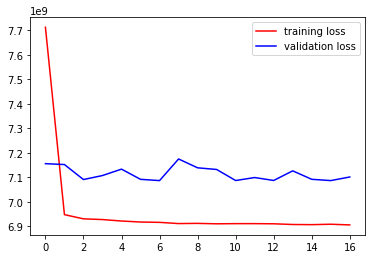

In [19]:
## visualizing the train and validation loss
plt.plot(history.history['loss'],color='red',label='training loss')
plt.plot(history.history['val_loss'],color='blue',label='validation loss')
plt.legend()
plt.show()

In [20]:
## Let's load the test data
test = pd.read_csv("/kaggle/input/customer-life-time-prediction/test_koRSKBP.csv")
test.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,89393,Female,Rural,High School,5L-10L,0,6,2134,More than 1,B,Silver
1,89394,Female,Urban,High School,2L-5L,0,4,4102,More than 1,A,Platinum
2,89395,Male,Rural,High School,5L-10L,1,7,2925,More than 1,B,Gold
3,89396,Female,Rural,Bachelor,More than 10L,1,2,0,More than 1,B,Silver
4,89397,Female,Urban,High School,2L-5L,0,5,14059,More than 1,B,Silver


In [21]:
## creating a prediction dataframe
predictions = pd.DataFrame()
predictions['id'] = test['id']

In [22]:
## removing id column from test
test.drop('id',axis=1, inplace=True)

In [23]:
test.head()

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,Female,Rural,High School,5L-10L,0,6,2134,More than 1,B,Silver
1,Female,Urban,High School,2L-5L,0,4,4102,More than 1,A,Platinum
2,Male,Rural,High School,5L-10L,1,7,2925,More than 1,B,Gold
3,Female,Rural,Bachelor,More than 10L,1,2,0,More than 1,B,Silver
4,Female,Urban,High School,2L-5L,0,5,14059,More than 1,B,Silver


In [24]:
## replacing outliers from the column claim_amount with the median of the column
quantiles = pd.DataFrame(test['claim_amount']).quantile(np.arange(0,1,0.25)).T
quantiles = quantiles.rename(columns={0.25:'Q1', 0.50: 'Q2', 0.75:'Q3'})

quantiles['IQR'] = quantiles['Q3'] - quantiles['Q1']
quantiles['Lower_Limit'] = quantiles['Q1'] - 1.5*quantiles['IQR']
quantiles['Upper_Limit'] = quantiles['Q3'] + 1.5*quantiles['IQR']

test['claim_amount'] = np.where((test['claim_amount'] < quantiles.loc['claim_amount','Lower_Limit']) | (test['claim_amount'] > quantiles.loc['claim_amount','Upper_Limit']) & (test['claim_amount'] is not np.nan), np.nan, test['claim_amount'])

In [25]:
## dealing with the missing values in numerical and categorical features

test['claim_amount'] = imputer1.transform(test['claim_amount'].to_numpy().reshape(-1,1))

for feature in cat_feat + ['vintage', 'marital_status']:
    test[feature] = inputer2.transform(test[feature].to_numpy().reshape(-1,1))

In [26]:
## dealing with the scaling of numerical feature
test['claim_amount'] = mms.transform(test['claim_amount'].to_numpy().reshape(-1,1))
## applying log-transformation to the claim amount feature
test['claim_amount'] = np.log(test['claim_amount'])

## dealing with the encoding of categorical feature
test['income']  = oe1.transform(test['income'].to_numpy().reshape(-1,1))
test['qualification']  = oe2.transform(test['qualification'].to_numpy().reshape(-1,1))
test['type_of_policy']  = oe3.transform(test['type_of_policy'].to_numpy().reshape(-1,1))

transformed=transformer.transform(test)
test=pd.DataFrame(transformed,columns=transformer.get_feature_names_out())

In [27]:
test

,gender_Male,area_Urban,policy_B,policy_C,num_policies_More than 1,qualification,income,marital_status,vintage,claim_amount,type_of_policy
0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,6.0,-1.651645,2.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,-1.023510,1.0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,7.0,-1.350554,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,2.0,-4.605170,2.0
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,5.0,-1.028812,2.0
...,...,...,...,...,...,...,...,...,...,...,...
59590,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,-4.605170,2.0
59591,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,6.0,-4.605170,0.0
59592,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,4.0,-1.227613,1.0
59593,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.363455,2.0


In [28]:
test_pred = model.predict(test)

In [29]:
predictions['cltv'] = test_pred

In [30]:
predictions.head()

,id,cltv
0,89393,93190.671875
1,89394,129629.335938
2,89395,91403.640625
3,89396,88514.554688
4,89397,113941.187500


In [31]:
predictions.to_csv('/kaggle/working/predictions_ann.csv', index=False)